## Step-1: Importing Modules

In [ ]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#For K-Means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
#For Hierarcial clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [ ]:
#For K-Modes clustering
!pip install kmodes

from kmodes.kmodes import KModes
from sklearn import preprocessing

In [116]:
#For K-Prototype clustering
from kmodes.kprototypes import KPrototypes

## Step-2: Reading and understanding the data

In [ ]:
retail = pd.read_csv('Online_Retail.csv',sep=',', encoding='latin-1')
retail.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Online_Retail.csv'

In [ ]:
retail.columns

In [ ]:
retail.info()

In [ ]:
retail.describe()

In [ ]:
retail.shape

In [ ]:
#checking the null values in the data
round(retail.isnull().sum()/len(retail)*100,2)

In [ ]:
#drop the null valued rows from the data
retail = retail.dropna()
retail.shape

In [ ]:
# new column: amount
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
retail.head()

## Step-3: Data Preparation

We are going to analysis the Customers based on below 3 factors:

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

### Monetary

In [ ]:
#Monetary
monetary_df = retail.groupby('CustomerID')['Amount'].sum()

In [ ]:
monetary_df = monetary_df.reset_index()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

### Frequency

In [ ]:
#Frequency
frequency_df = retail.groupby('CustomerID')['InvoiceNo'].count()

In [ ]:
frequency_df = frequency_df.reset_index()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

In [ ]:
retail_df = pd.merge(monetary_df,frequency_df,on='CustomerID', how='inner')
retail_df.head()

In [ ]:
retail_df.shape

### Recency

In [ ]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail.head()

In [ ]:
# compute the max date
max_date = max(retail['InvoiceDate'])
max_date

In [ ]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

In [ ]:
retail['Diff'] = retail['Diff'].dt.days
retail.head()

In [ ]:
recency_df = retail.groupby('CustomerID')['Diff'].min()
recency_df = recency_df.reset_index()
recency_df.columns = ['CustomerID','Recency']
recency_df.head()

In [ ]:
# merge
retail_df = pd.merge(retail_df, recency_df, on='CustomerID', how='inner')
#retail_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
retail_df.head()

### Outliers Detection

In [ ]:
for col in ['Monetary','Frequency','Recency']:
  plt.figure(figsize=(10,5))
  sns.boxplot(retail_df[col],color='blue')
  plt.title(col, color='red')
  plt.show()

In [ ]:
for col in ['Monetary','Frequency','Recency']:
  q1=retail_df[col].describe()["25%"]
  q3=retail_df[col].describe()["75%"]
  iqr=q3-q1 #interquartile range
  lower_bound=q1-1.5*iqr
  upper_bound=q3+1.5*iqr
  retail_df[col]=np.where(retail_df[col]>upper_bound,upper_bound,retail_df[col])
  retail_df[col]=np.where(retail_df[col]<lower_bound,lower_bound,retail_df[col])
  sns.boxplot(retail_df[col],color='blue')
  plt.title(col, color='red')
  plt.show()

**Rescaling**

In [ ]:
# Instantiate
scaler = StandardScaler()

# fit_transform
retail_df_scaled = scaler.fit_transform(retail_df[['Monetary','Frequency','Recency']])
retail_df_scaled.shape

In [ ]:
retail_df_scaled= pd.DataFrame(retail_df_scaled)
retail_df_scaled.columns = ['Monetary','Frequency','Recency']
retail_df_scaled.head()

**The data is ready for modelling**

## Step-4: Model Building

### K-Means Clustering

**K-Means Clustering works on purely numerical data files**

In [ ]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(retail_df_scaled)

In [ ]:
kmeans.labels_

In [ ]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(retail_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [ ]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(retail_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(retail_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For k=3 the silhouette score is high, we can consider and build the model with 3 clusters.

In [ ]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(retail_df_scaled)

In [ ]:
labels = kmeans.labels_
print(labels)

In [ ]:
labels = pd.DataFrame(labels)
labels.columns = ['labels']
labels.value_counts()

In [ ]:
# assign the label
retail_df['cluster_id'] = kmeans.labels_
retail_df.head()

In [ ]:
sns.boxplot(x='cluster_id',y='Monetary',data=retail_df)

In [ ]:
sns.boxplot(x='cluster_id',y='Frequency',data=retail_df)

In [ ]:
sns.boxplot(x='cluster_id',y='Recency',data=retail_df)

Inference:

K-Means Clustering with 3 Cluster Ids

- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.

- Customers with Cluster Id 1 are frequent buyers.

- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

### Hierarcial Clustering

**Hierarcial Clustering works on purely numerical data files**

In [ ]:
retail_df_scaled.head()

In [ ]:
retail_df.head()

In [ ]:
#Single linkage
merge = linkage(retail_df_scaled, method="single", metric="euclidean")
dendrogram(merge)
plt.show()

In [ ]:
#Complete Linkage
merge = linkage(retail_df_scaled, method="complete", metric="euclidean")
dendrogram(merge)
plt.show()

In [ ]:
#Average Linkage
merge = linkage(retail_df_scaled, method="average", metric="euclidean")
dendrogram(merge)
plt.show()

In [ ]:
cluster_labels = cut_tree(merge,n_clusters=3).reshape(-1)

In [ ]:
retail_df['cluster_labels'] = cluster_labels
retail_df.head()

In [ ]:
sns.boxplot(x='cluster_labels',y='Frequency',data=retail_df)

In [ ]:
sns.boxplot(x='cluster_labels',y='Monetary',data=retail_df)

In [ ]:
sns.boxplot(x='cluster_labels',y='Recency',data=retail_df)

Hierarchical Clustering with 3 Cluster Labels

- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.

- Customers with Cluster_Labels 2 are frequent buyers.

- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

## K-Mode Clustering

**K-Mode Clustering works on purely categorical data files**

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
bank = pd.read_csv('bankmarketing.csv')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
bank.shape

(41188, 21)

In [ ]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
bank_cat = bank[['age','job', 'marital', 'education', 'default', 'housing', 'loan','contact','month','day_of_week','poutcome']]
bank_cat.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [ ]:
bank_cat.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [ ]:
bank_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  poutcome     41188 non-null  object
dtypes: int64(1), object(10)
memory usage: 3.5+ MB


**Convert age column into a categorical column**

In [ ]:
bank_cat['age_bin'] = pd.cut(bank['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])
bank_cat.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60
2,37,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40
4,56,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60


In [ ]:
bank_cat = bank_cat.drop('age',axis=1)

In [ ]:
bank_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60


In [ ]:
bank_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   job          41188 non-null  object  
 1   marital      41188 non-null  object  
 2   education    41188 non-null  object  
 3   default      41188 non-null  object  
 4   housing      41188 non-null  object  
 5   loan         41188 non-null  object  
 6   contact      41188 non-null  object  
 7   month        41188 non-null  object  
 8   day_of_week  41188 non-null  object  
 9   poutcome     41188 non-null  object  
 10  age_bin      41188 non-null  category
dtypes: category(1), object(10)
memory usage: 3.2+ MB


In [ ]:
#Mapping labels to numerical values using LabelEncoder()
le = preprocessing.LabelEncoder()
bank_cat= bank_cat.apply(le.fit_transform)
bank_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,3,1,0,0,0,0,1,6,1,1,4
1,7,1,3,1,0,0,1,6,1,1,4
2,7,1,3,0,2,0,1,6,1,1,2
3,0,1,1,0,0,0,1,6,1,1,2
4,7,1,3,0,0,2,1,6,1,1,4


In [80]:
jobcounts = bank_cat['job'].value_counts()
jobcounts = jobcounts.sort_index()
jobcounts

job
0     10422
1      9254
2      1456
3      1060
4      2924
5      1720
6      1421
7      3969
8       875
9      6743
10     1014
11      330
Name: count, dtype: int64

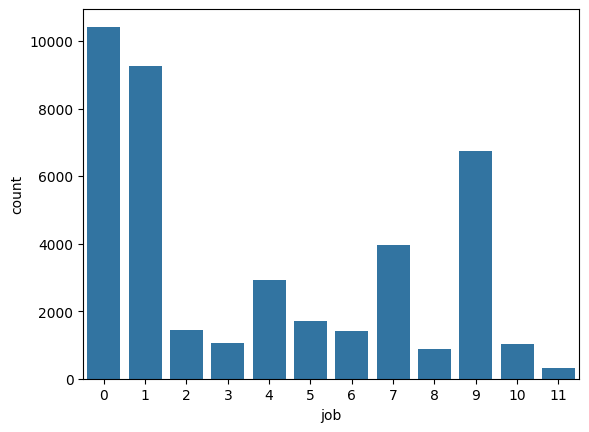

In [73]:
sns.barplot(x=jobcounts.index, y=jobcounts)
plt.show()

In [79]:
agecounts = bank_cat['age_bin'].value_counts()
agecounts = agecounts.sort_index()
agecounts

age_bin
0      140
1     7243
2    16385
3    10240
4     6270
5      488
6      303
7      109
8       10
Name: count, dtype: int64

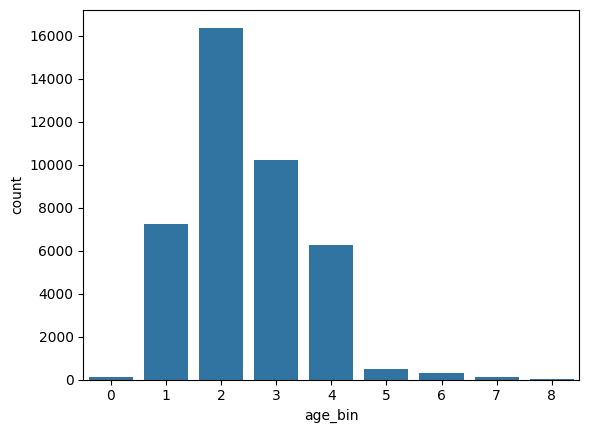

In [76]:
sns.barplot(x=agecounts.index, y=agecounts)
plt.show()

**Using Cao in KModes**

In [81]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cat)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


In [82]:
# Predicted Clusters
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

In [84]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = bank_cat.columns

In [85]:
# Mode of the clusters
clusterCentroidsDf

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,0,1,6,0,2,0,0,6,2,1,2
1,1,1,3,0,0,0,1,6,0,1,3


**Using Huang in KModes**

In [87]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cat)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3733, cost: 202846.0


In [88]:
# Predicted clusters
fitClusters_huang

array([0, 0, 1, ..., 0, 0, 0], dtype=uint16)

**Choosing Optimal K by comparing Cost against each K**

In [89]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(bank_cat)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 216952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4993, cost: 185138.0
Run 1, iteration: 2/100, moves: 1368, cost: 185138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6186, cost: 179774.0
Run 1, iteration: 2/100, moves: 1395, cost: 179774.0


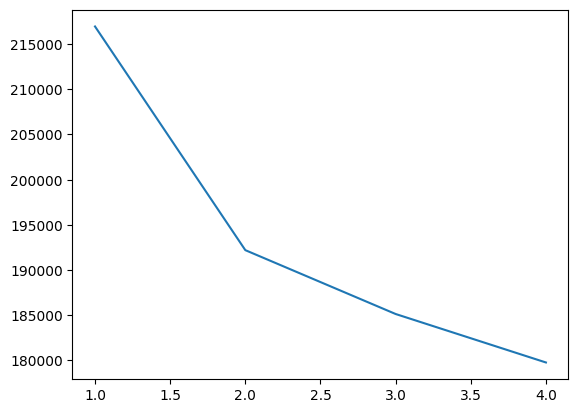

In [90]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [91]:
# Choosing K=2 as optimum number
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cat)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


In [92]:
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

**Combining the predicted clusters with the original DF**

In [93]:
bank_cat = bank_cat.reset_index()
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cat, clustersDf], axis = 1).reset_index()
combinedDf.head()

,level_0,index,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin,cluster_predicted
0,0,0,3,1,0,0,0,0,1,6,1,1,4,1
1,1,1,7,1,3,1,0,0,1,6,1,1,4,1
2,2,2,7,1,3,0,2,0,1,6,1,1,2,0
3,3,3,0,1,1,0,0,0,1,6,1,1,2,0
4,4,4,7,1,3,0,0,2,1,6,1,1,4,1


In [94]:
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [95]:
combinedDf.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin,cluster_predicted
0,3,1,0,0,0,0,1,6,1,1,4,1
1,7,1,3,1,0,0,1,6,1,1,4,1
2,7,1,3,0,2,0,1,6,1,1,2,0
3,0,1,1,0,0,0,1,6,1,1,2,0
4,7,1,3,0,0,2,1,6,1,1,4,1


In [132]:
no_of_clusters = combinedDf['cluster_predicted'].value_counts()
no_of_clusters

cluster_predicted
0    28293
1    12895
Name: count, dtype: int64

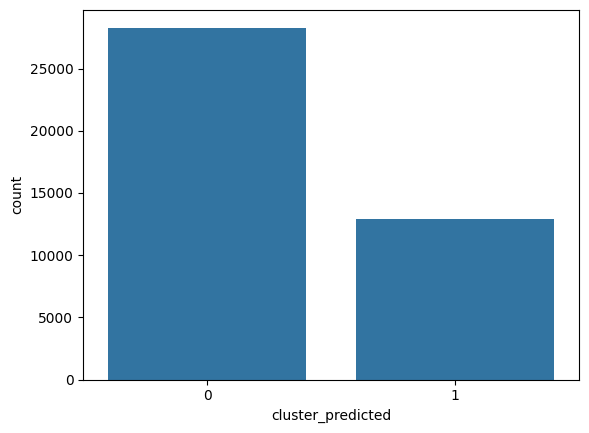

In [133]:
sns.barplot(x=no_of_clusters.index,y=no_of_clusters)
plt.show()

In [96]:
# Data for Cluster1
cluster1 = combinedDf[combinedDf.cluster_predicted==1]

In [97]:
# Data for Cluster0
cluster0 = combinedDf[combinedDf.cluster_predicted==0]

In [98]:
cluster1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12895 entries, 0 to 41186
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                12895 non-null  int64 
 1   marital            12895 non-null  int64 
 2   education          12895 non-null  int64 
 3   default            12895 non-null  int64 
 4   housing            12895 non-null  int64 
 5   loan               12895 non-null  int64 
 6   contact            12895 non-null  int64 
 7   month              12895 non-null  int64 
 8   day_of_week        12895 non-null  int64 
 9   poutcome           12895 non-null  int64 
 10  age_bin            12895 non-null  int64 
 11  cluster_predicted  12895 non-null  uint16
dtypes: int64(11), uint16(1)
memory usage: 1.2 MB


In [99]:
cluster0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28293 entries, 2 to 41187
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                28293 non-null  int64 
 1   marital            28293 non-null  int64 
 2   education          28293 non-null  int64 
 3   default            28293 non-null  int64 
 4   housing            28293 non-null  int64 
 5   loan               28293 non-null  int64 
 6   contact            28293 non-null  int64 
 7   month              28293 non-null  int64 
 8   day_of_week        28293 non-null  int64 
 9   poutcome           28293 non-null  int64 
 10  age_bin            28293 non-null  int64 
 11  cluster_predicted  28293 non-null  uint16
dtypes: int64(11), uint16(1)
memory usage: 2.6 MB


In [100]:
# Checking the count per category for JOB cluster wise
job1_df = cluster1['job'].value_counts()
job1_df = job1_df.sort_index()
job1_df

job
0     1411
1     5125
2      434
3      370
4      656
5      459
6      322
7     1741
8      239
9     1661
10     345
11     132
Name: count, dtype: int64

In [101]:
# Checking the count per category for JOB cluster wise
job0_df = cluster0['job'].value_counts()
job0_df = job0_df.sort_index()
job0_df

job
0     9011
1     4129
2     1022
3      690
4     2268
5     1261
6     1099
7     2228
8      636
9     5082
10     669
11     198
Name: count, dtype: int64

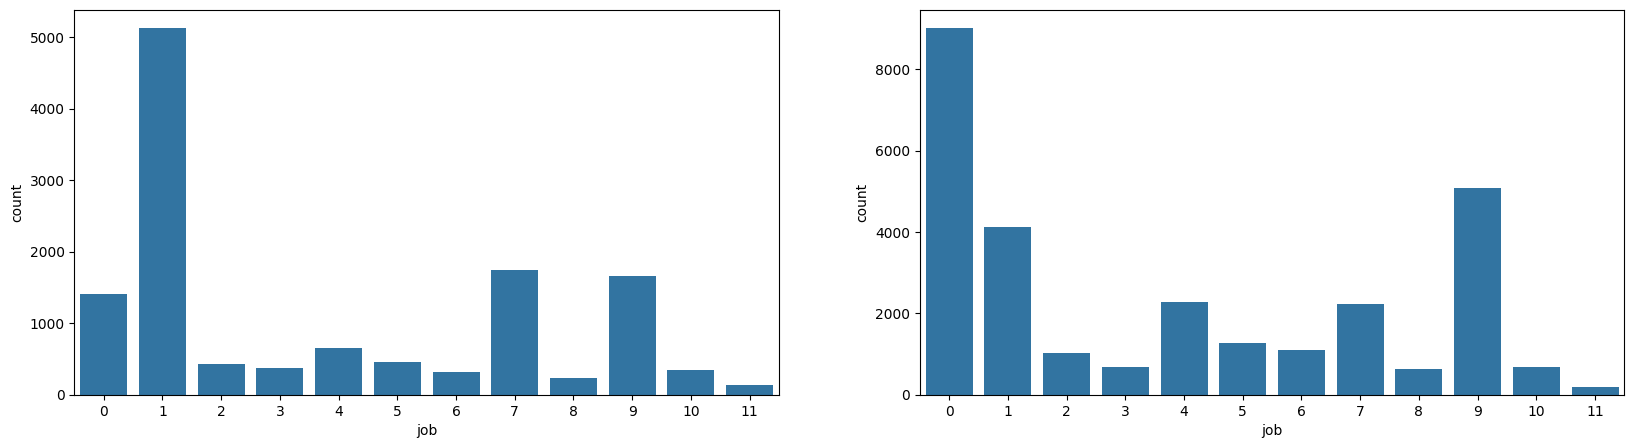

In [102]:
fig, ax =plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=job1_df.index, y=job1_df, ax=ax[0])
sns.barplot(x=job0_df.index, y=job0_df, ax=ax[1])
fig.show()

In [105]:
# Checking the count per category for age_bin cluster wise
age0_df = cluster0['age_bin'].value_counts()
age0_df = age0_df.sort_index()
age0_df

age_bin
0      108
1     4972
2    13517
3     4687
4     4245
5      403
6      254
7       97
8       10
Name: count, dtype: int64

In [106]:
# Checking the count per category for age_bin cluster wise
age1_df = cluster1['age_bin'].value_counts()
age1_df = age1_df.sort_index()
age1_df

age_bin
0      32
1    2271
2    2868
3    5553
4    2025
5      85
6      49
7      12
Name: count, dtype: int64

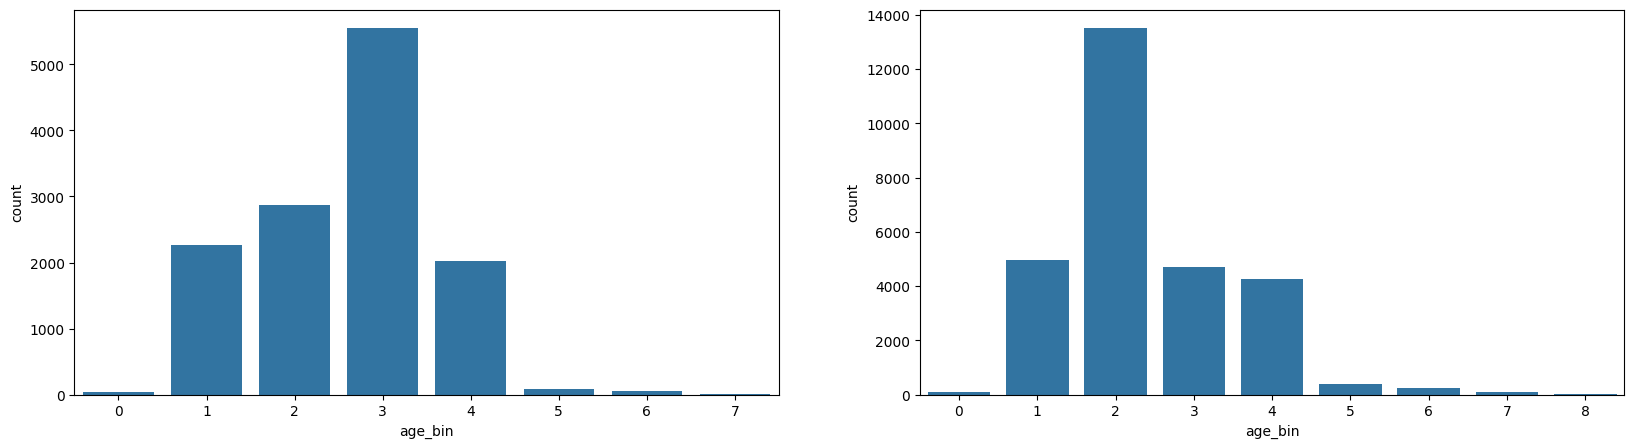

In [108]:
fig, ax =plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=age1_df.index, y=age1_df, ax=ax[0])
sns.barplot(x=age0_df.index, y=age0_df, ax=ax[1])
fig.show()

In [103]:
print(cluster1['marital'].value_counts())
print(cluster0['marital'].value_counts())

marital
1    8636
2    2732
0    1501
3      26
Name: count, dtype: int64
marital
1    16292
2     8836
0     3111
3       54
Name: count, dtype: int64


In [104]:
print(cluster1['education'].value_counts())
print(cluster0['education'].value_counts())

education
3    4186
2    2572
0    1981
5    1459
1    1033
6     977
7     680
4       7
Name: count, dtype: int64
education
6    11191
3     5329
5     3784
2     3473
0     2195
1     1259
7     1051
4       11
Name: count, dtype: int64


# K-Prototype Clustering

**K-Prototype Clustering is used on the data which contains both numerical and categorical data**

**About Blood Transfusion dataset**<br><br>
To demonstrate the RFMTC marketing model (a modified version of RFM), this study adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. To build a FRMTC model, we selected 748 donors at random from the donor database. These 748 donor data, each one included R (Recency - months since last donation), F (Frequency - total number of donation), M (Monetary - total blood donated in c.c.), T (Time - months since first donation), and a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).

**Attribute Information:**

- R (Recency - months since last donation),
- F (Frequency - total number of donation),
- M (Monetary - total blood donated in c.c.),
- T (Time - months since first donation), and a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).

- Variable	Data Type	Measurement	Description	min	max	mean	std
- Recency quantitative	Months	Input	0.03	74.4	9.74	8.07
- Frequency quantitative	Times	Input	1	50	5.51	5.84
- Monetary	quantitative	c.c. blood	Input	250	12500	1378.68	1459.83
- Time quantitative	Months	Input	2.27	98.3	34.42	24.32
- Whether he/she donated blood in March 2007	binary	1=yes 0=no	Output	0	1	1 (24%) 0 (76%)

In [111]:
# Reading Dataset
blood = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data', sep=",",engine = 'python')

In [112]:
#Sanity Check
blood.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [113]:
# standardizing data
columns_to_normalize     = ['Recency (months)','Frequency (times)','Monetary (c.c. blood)','Time (months)']
blood[columns_to_normalize] = blood[columns_to_normalize].apply(lambda x: (x - x.mean()) / np.std(x))

In [114]:
# Re-check after standardizing data
blood.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,-0.927899,7.623346,7.623346,2.615633,1
1,-1.175118,1.282738,1.282738,-0.257881,1
2,-1.051508,1.796842,1.796842,0.029471,1
3,-0.927899,2.482313,2.482313,0.439973,1
4,-1.051508,3.167784,3.167784,1.753579,0


In [117]:
# Converting the dataset into matrix
blood_matrix = blood.to_numpy()

In [118]:
# Martix for analysis
blood_matrix

array([[-0.92789873,  7.62334626,  7.62334626,  2.61563344,  1.        ],
       [-1.17511806,  1.28273826,  1.28273826, -0.2578809 ,  1.        ],
       [-1.0515084 ,  1.79684161,  1.79684161,  0.02947053,  1.        ],
       ...,
       [ 1.66790417, -0.43093957, -0.43093957,  1.13782607,  0.        ],
       [ 3.64565877, -0.77367514, -0.77367514,  0.19367135,  0.        ],
       [ 7.72477762, -0.77367514, -0.77367514,  1.54832812,  0.        ]])

In [119]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=5, init='Cao')
clusters = kproto.fit_predict(blood_matrix, categorical=[4])

In [120]:
kproto.cluster_centroids_

array([[-0.52616733,  6.10245718,  6.10245718,  2.44630135,  1.        ],
       [ 1.15986255, -0.4965349 , -0.4965349 , -0.17872668,  0.        ],
       [-0.26291005,  1.64282753,  1.64282753,  1.44232506,  0.        ],
       [-0.29352462,  0.23674811,  0.23674811,  0.56815766,  0.        ],
       [-0.64668675, -0.52090766, -0.52090766, -0.90254016,  0.        ]])

In [121]:
# Checking the cost of the clusters created.
kproto.cost_

909.3681461274577

In [122]:
# Adding the predicted clusters to the main dataset
blood['cluster_id'] = clusters

In [123]:
# Re-check
blood.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007,cluster_id
0,-0.927899,7.623346,7.623346,2.615633,1,0
1,-1.175118,1.282738,1.282738,-0.257881,1,3
2,-1.051508,1.796842,1.796842,0.029471,1,2
3,-0.927899,2.482313,2.482313,0.439973,1,2
4,-1.051508,3.167784,3.167784,1.753579,0,2


In [128]:
# Checking the clusters created
blooddf = blood['cluster_id'].value_counts()
blooddf

cluster_id
4    240
3    212
1    209
2     79
0      8
Name: count, dtype: int64

<Axes: xlabel='cluster_id', ylabel='count'>

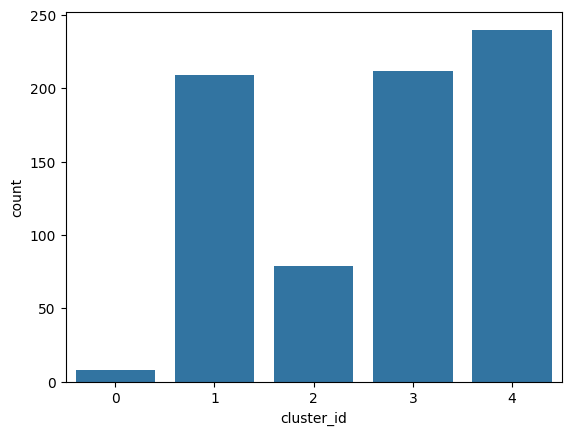

In [129]:
sns.barplot(x=blooddf.index, y=blooddf)